<a href="https://colab.research.google.com/github/ankitagithub13/capstone-chatbot/blob/dev_capstone_preprocessing/RegExDataProcess_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import spacy
import nltk
import re

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk import stem,tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize,stem
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
df = pd.read_csv('Data Set - industrial_safety_and_health_database_with_accidents_description.csv',index_col=False)

In [7]:
print(df.shape)

df.head()

(425, 11)


,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


**Data** **Cleaning**

In [8]:
# Drop and Rename Columns 
df.drop("Unnamed: 0", axis=1, inplace=True)
df.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee type'}, inplace=True)
df.head(3)

,Date,Country,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee type,Critical Risk,Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...


In [9]:
df.columns

Index(['Date', 'Country', 'Local', 'Industry Sector', 'Accident Level',
       'Potential Accident Level', 'Gender', 'Employee type', 'Critical Risk',
       'Description'],
      dtype='object')

In [10]:
# Display info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Date                      425 non-null    object
 1   Country                   425 non-null    object
 2   Local                     425 non-null    object
 3   Industry Sector           425 non-null    object
 4   Accident Level            425 non-null    object
 5   Potential Accident Level  425 non-null    object
 6   Gender                    425 non-null    object
 7   Employee type             425 non-null    object
 8   Critical Risk             425 non-null    object
 9   Description               425 non-null    object
dtypes: object(10)
memory usage: 33.3+ KB


In [11]:
# Check Null Values
df.isnull().sum()

Date                        0
Country                     0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee type               0
Critical Risk               0
Description                 0
dtype: int64

# 1 : NLP pre-processing

In [78]:
%%writefile PreProcessingfile.py

"""text_preprocess

"""

# Import packages
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import string

# nltk.download('averaged_perceptron_tagger')


def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

def getRegexList():
    '''
    Adding regex list as per the given data set to flush off the unnecessary text
    
    '''
    regexList = [] 
    regexList += ['[^a-zA-z 0-9]+']  # anything that is not a letter
    regexList += ['[\n]']  # \n new line
    regexList += [' [a-zA-Z] ']  # single letters makes no sense
    regexList += [' [a-zA-Z][a-zA-Z] ']  # two-letter words makes no sense
    regexList += ['[\s]{2,}']  # more than one space
    regexList += ['[^a-zA-Z]']  #remove numbers

    return regexList

#Convert all word to lower case
def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

# Remove Space
def removeSpace(data):
    return data.strip()

#Remove Accented chars
def remove_accented_chars(data):
    return  unicodedata.normalize('NFKD', data.values.tolist()).encode('ascii', 'ignore').decode('utf-8', 'ignore')

#New cleaned dataframe with 'CleanDescription' column
def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)          
    
    return dataset
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}

# Function to Replace appos
def replace_words(description):
    cleaned_description = []
    for word in str(description).split():
        if word.lower() in appos.keys():
            cleaned_description.append(appos[word.lower()])
        else:
            cleaned_description.append(word)
    return ' '.join(cleaned_description)

# Function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

# Function to Remove Stopwords
stoplist = set(stopwords.words('english'))
stoplist.update(('cm', 'kg', 'mr', 'wa' ,'nv', 'ore', 'da', 'pm', 'am', 'cx'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])



Overwriting PreProcessingfile.py


In [72]:
# Text preprocessing and stopwords
from PreProcessingfile import * #(customized module)

In [16]:
x = df['Description']
# print('||'.join(x))
string_d = '||'.join(x)

In [ ]:
# How many sentences in Data/Plot/Visualisation delimited by fullstop
#add the words which we want to keep at the end of the preprocess steps

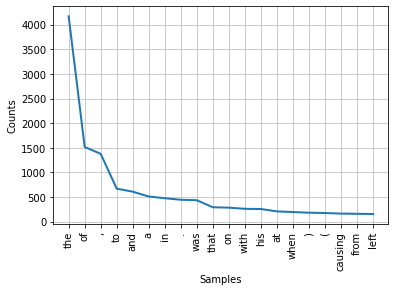

In [17]:
word_token = word_tokenize(string_d)
# print(word_token)

cts = nltk.FreqDist(word_token)
cts.plot(20)

In [32]:
# len = len(getRegexList())
g = getRegexList()
g

[' +', '[^a-zA-z 0-9]+', '[\n]', ' [a-zA-Z] ', ' [a-zA-Z][a-zA-Z] ', '\\s +']

In [79]:
# Apply Data Preprocessing functions

#Create new Column for processing:
df['CleanDescription'] = df['Description']

#Columns to clean
columnsToClean = ['CleanDescription']

# Clean dataset and remove sensitive data
df_cleanedtxts = cleanDataset(df, columnsToClean, getRegexList())

# Removing stop words
df_cleanedtxts['CleanDescription'] = df_cleanedtxts['CleanDescription'].apply(lambda x: remove_stopwords(x))

# Applying Lemmatizer
df_cleanedtxts['CleanDescription'] = df_cleanedtxts['CleanDescription'].apply(lambda x: lemmatize(x))


In [80]:
df['CleanDescription'][3]

'Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the "DADO" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.'

In [64]:
df_cleanedtxts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Date                      425 non-null    object
 1   Country                   425 non-null    object
 2   Local                     425 non-null    object
 3   Industry Sector           425 non-null    object
 4   Accident Level            425 non-null    object
 5   Potential Accident Level  425 non-null    object
 6   Gender                    425 non-null    object
 7   Employee type             425 non-null    object
 8   Critical Risk             425 non-null    object
 9   Description               425 non-null    object
 10  CleanDescription          425 non-null    object
 11  line_length               425 non-null    int64 
dtypes: int64(1), object(11)
memory usage: 40.0+ KB


In [47]:
## Removal of Stop Words
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')

# stop = stopwords.words('english')
# # stop

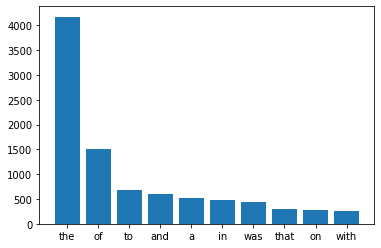

In [56]:
# pLot top stopwords
plot_top_stopwords_barchart(df['Description'])

In [65]:
df_cleanedtxts['CleanDescription']

0      removingdrillrodjumbo08maintenancesupervisorpr...
1      activationsodiumsulphidepumppipinguncoupledsul...
2      substationmilpolocatedlevel170collaboratorexca...
3      945approximately1880695ob7personnelbeginstasku...
4      approximately1145circumstancesmechanicsanthony...
                             ...                        
420    approximately500approximatelyliftingkellytowar...
421    collaboratormovedinfrastructureofficejuliotoil...
422    environmentalmonitoringactivityareaemployeesur...
423    employeeperformedactivitystrippingcathodespull...
424    1000assistantcleanedfloormodulecentralcampslip...
Name: CleanDescription, Length: 425, dtype: object

In [58]:
x2 = df_cleanedtxts['CleanDescription']

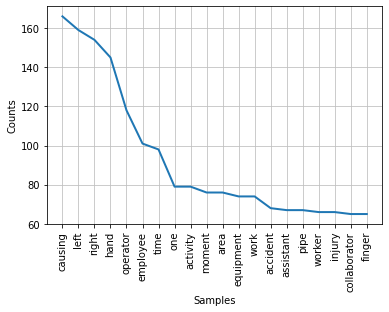

In [49]:
# Cleaned Description Plot
string_d2 = '||'.join(x2)

word_token = word_tokenize(string_d2)
# print(word_token)

cts = nltk.FreqDist(word_token)
cts.plot(20)

We can evidently see that stopwords such as “the”,” to” dominate in Decription Column.

In [59]:
df_cleanedtxts[['Description','CleanDescription']].head()

,Description,CleanDescription
0,While removing the drill rod of the Jumbo 08 f...,removing drill rod jumbo 08 maintenance superv...
1,During the activation of a sodium sulphide pum...,activation sodium sulphide pump piping uncoupl...
2,In the sub-station MILPO located at level +170...,sub station milpo located level 170 collaborat...
3,Being 9:45 am. approximately in the Nv. 1880 C...,9 45 approximately 1880 695 ob7 personnel begi...
4,Approximately at 11:45 a.m. in circumstances t...,approximately 11 45 circumstances mechanics an...


In [60]:
df_cleanedtxts['Description'][3]

'Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the "DADO" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.'

In [61]:
df_cleanedtxts['CleanDescription'][3]

'9 45 approximately 1880 695 ob7 personnel begins task unlocking soquet bolts bhb machine penultimate bolt identified hexagonal head worn proceeding crist bal auxiliary assistant climb platform exert pressure hand dado key prevent coming bolt moments two collaborators rotate lever anti clockwise direction leaving key bolt hitting palm left hand causing injury'

In [91]:
# Get the minimum & maximum length

df['line_length'] = df['CleanDescription'].str.len()

print('Minimum line length: {}'.format(df['line_length'].min()))
print('Maximum line length: {}'.format(df['line_length'].max()))
print('Line with maximum length: {}'.format(df[df['line_length'] == df['line_length'].max()]['CleanDescription'].values[0]))

Minimum line length: 61
Maximum line length: 681
Line with maximum length: level 3490 gallery 239 holding activity bolter equipment 24 operator performs drilling first hole support right gable 7 foot deep drill end drill rod breaks leaving threads inside drilling machine shank operator assistant decide make two empty percussion attempts free threads shank without success third attempt assistant enters 3 8 corrugated iron central hole rest bar embedded shank generate pressure moment operator activates percussion generates movement shank hits palm victim left hand generating described injury worker wearing safety gloves time accident end corrugated iron contact left hand shaped like cane worker time accident positioned roof supported mesh split set


In [53]:
df['line_length'] = df['CleanDescription'].str.len()

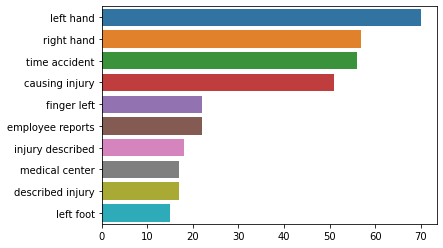

In [109]:
top_n_bigrams=get_top_ngram(df_cleanedtxts['CleanDescription'],2)[:10]
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

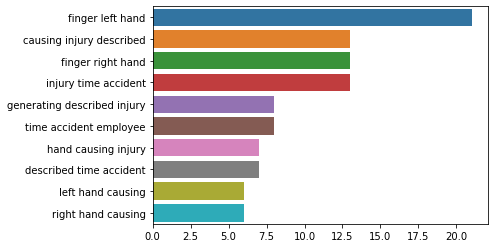

In [110]:
top_tri_grams=get_top_ngram(df_cleanedtxts['CleanDescription'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

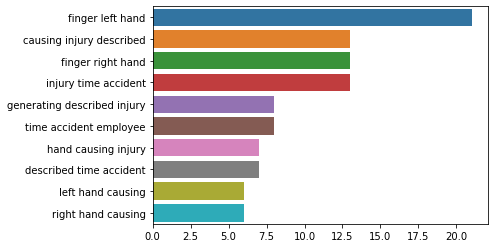

In [112]:
top_tri_grams=get_top_ngram(df_cleanedtxts['CleanDescription'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

df_finaltxts = df_cleanedtxts
df_finaltxts = df_finaltxts.drop(['Description'],axis=1)
# df_finaltxts.head(5)

**WordCloud**

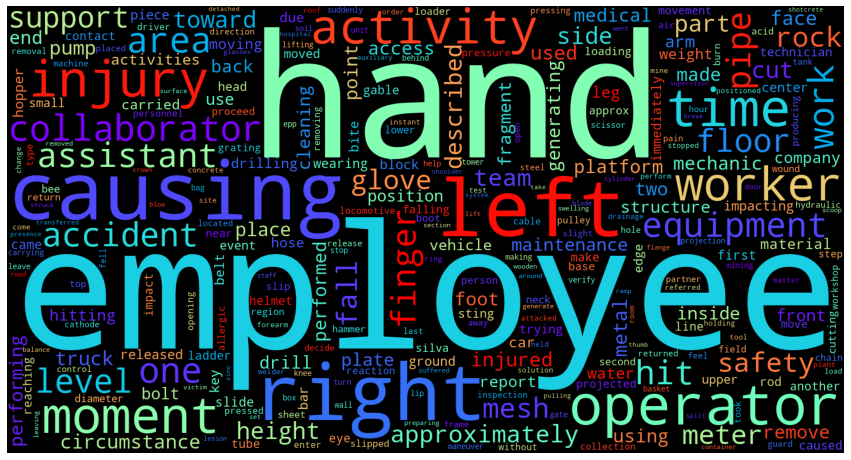

In [113]:
wordcloud = WordCloud(width = 1500, height = 800, random_state=0, background_color='black', colormap='rainbow', \
                      min_font_size=5, max_words=300, collocations=False).generate(" ".join(df_finaltxts['CleanDescription'].values))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Observations**:

There are many Body related, Worker/Employee/Operator related,left right movement related,equipments related,injury related,time related words can see observed.

# What we can try next:
Converting to lower case;

Removing single letters (makes no sense);

Removing punctuations;

Removing multiple spaces between words;

Removing stop words

Lemmatizer-if require

In [ ]:
# count of patterns in data column
for i in range(len):  
  pattern_i = re.compile(getRegexList()[i])
  print('regex -', i , pattern_i)
    
  matches = pattern_i.finditer(' '.join(x))
  counter = 0
  for mat in matches: 
      counter = counter+1
  print('count:', counter)

regex - 0 re.compile('[^a-zA-z 0-9]+')
count: 3357
regex - 1 re.compile('[\n]')
count: 0
regex - 2 re.compile(' [a-zA-Z] ')
count: 585
regex - 3 re.compile(' [a-zA-Z][a-zA-Z] ')
count: 4178
regex - 4 re.compile('  ')
count: 0
regex - 5 re.compile('[^a-zA-Z]')
count: 33543


# **TRY**

In [ ]:
# anything that is not a letter
pattern1 = re.compile(r'[^a-zA-z 0-9]+') 
matches = pattern5.finditer(' '.join(x))
counter = 0
for mat in matches: 
    counter = counter+1
print('anything that is not a letter:', counter)

anything that is not a letter: 3357


Converting description to lower case;
Removing punctuations;Removing multiple spaces between words;Removing stop words

**WordCloud**

Observations:

There are many body-related, employee related, movement-related, equipment-related and accident-related words.

Body-related: left, right, hand, finger, face, foot and glove
Employee-related: employee, operator, collaborator, assistant, worker and mechanic
Movement-related: fall, hit, lift and slip
Equipment-related: equipment, pump, meter, drill, truck and tube
Accident-related: accident, activity, safety, injury, causing